# Imports

In [5]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import datetime

%matplotlib inline
from finrl.config_tickers import DOW_30_TICKER
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent, DRLEnsembleAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

# import sys
# sys.path.append("../FinRL-Library")

import itertools

In [8]:
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

# Download Data

In [10]:
print(DOW_30_TICKER)

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


In [11]:
TRAIN_START_DATE = '2010-01-01'
TRAIN_END_DATE = '2021-10-01'
TEST_START_DATE = '2021-10-01'
TEST_END_DATE = '2023-03-01'

df = YahooDownloader(
    start_date=TRAIN_START_DATE,
    end_date=TEST_END_DATE,
    ticker_list = DOW_30_TICKER
).fetch_data()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Shape of DataFrame:  (97013, 8)


In [13]:
df.head()

,date,open,high,low,close,volume,tic,day
0,2010-01-04,7.622500,7.660714,7.585000,6.461976,493729600,AAPL,0
1,2010-01-04,56.630001,57.869999,56.560001,41.200798,5277400,AMGN,0
2,2010-01-04,40.810001,41.099998,40.389999,33.090431,6894300,AXP,0
3,2010-01-04,55.720001,56.389999,54.799999,43.777546,6186700,BA,0
4,2010-01-04,57.650002,59.189999,57.509998,40.190216,7325600,CAT,0


In [14]:
df.sort_values(['date','tic'],ignore_index=True).head()

,date,open,high,low,close,volume,tic,day
0,2010-01-04,7.622500,7.660714,7.585000,6.461976,493729600,AAPL,0
1,2010-01-04,56.630001,57.869999,56.560001,41.200798,5277400,AMGN,0
2,2010-01-04,40.810001,41.099998,40.389999,33.090431,6894300,AXP,0
3,2010-01-04,55.720001,56.389999,54.799999,43.777546,6186700,BA,0
4,2010-01-04,57.650002,59.189999,57.509998,40.190216,7325600,CAT,0


In [15]:
df.tic.value_counts()

tic
AAPL    3311
AMGN    3311
WMT     3311
WBA     3311
VZ      3311
V       3311
UNH     3311
TRV     3311
PG      3311
NKE     3311
MSFT    3311
MRK     3311
MMM     3311
MCD     3311
KO      3311
JPM     3311
JNJ     3311
INTC    3311
IBM     3311
HON     3311
HD      3311
GS      3311
DIS     3311
CVX     3311
CSCO    3311
CRM     3311
CAT     3311
BA      3311
AXP     3311
DOW      994
Name: count, dtype: int64

# Preprocess Data

In [16]:
fe = FeatureEngineer(
    use_technical_indicator=True,
    use_turbulence=True,
    user_defined_feature=False
)

processed = fe.preprocess_data(df)
processed = processed.copy()
processed = processed.fillna(0)
processed = processed.replace(np.inf, 0)

Successfully added technical indicators
Successfully added turbulence index


In [17]:
processed.sample(5)

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,turbulence
60562,2018-04-20,177.850006,178.889999,176.320007,152.997620,5008600,HD,4,-0.640002,155.397934,147.281737,48.276824,35.332716,3.030037,152.270734,157.050859,47.047583
38270,2015-04-01,54.637405,54.694656,53.645039,41.157814,13322386,MRK,2,-0.072151,42.882858,40.104836,45.420110,-87.361540,23.206678,41.642696,42.703928,47.911128
95212,2023-01-19,143.520004,146.679993,143.160004,146.219009,7070100,CRM,3,2.589884,154.559448,122.252959,51.463583,98.647925,20.995579,136.086567,144.265051,36.125735
40819,2015-08-06,42.000000,42.250000,41.860001,31.702351,11378900,KO,3,0.270982,31.852135,30.280532,59.269086,149.480186,34.078139,30.720976,30.665639,27.395694
14630,2012-01-03,65.589996,66.000000,65.250000,46.237446,16116200,JNJ,1,0.444457,46.709382,43.894389,55.640825,120.285799,7.982532,44.903140,44.771734,45.339625


# Design Environment

In [18]:
stock_dimension = len(processed.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 29, State Space: 291


In [19]:
env_kwargs = {
    "hmax": 100,
    "initial_amount": 1_000_000,
    "buy_cost_pct": 0.001,
    "sell_cost_pct": 0.001,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4,
    "print_verbosity": 5,
}

# Design Agents

In [20]:
rebalance_window = 63   # number of days to retrain the model
validation_window = 63  # number of days to do validation and trading

ensemble_agent = DRLEnsembleAgent(
    df=processed,
    train_period=(TRAIN_START_DATE, TRAIN_END_DATE),
    val_test_period=(TEST_START_DATE, TEST_END_DATE),
    rebalance_window=rebalance_window,
    validation_window=validation_window,
    **env_kwargs
)

In [30]:
A2C_model_kwargs = {
    'n_steps': 5,
    'ent_coef': 0.005,
    'learning_rate': 0.0007,
}

PPO_model_kwargs = {
    'ent_coef': 0.01,
    'n_steps': 2048,
    'learning_rate': 0.00025,
    'batch_size': 128,
}

DDPG_model_kwargs = {
    'buffer_size': 10_000,
    'learning_rate': 0.0005,
    'batch_size': 64,
}
SAC_model_kwargs = {
    "batch_size": 64,
    "buffer_size": 100000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}
TD3_model_kwargs = {
    "batch_size": 100,
    "buffer_size": 1000000,
    "learning_rate": 0.0001
}

timesteps_dict = {
    'a2c': 10_000,
    'ppo': 10_000,
    'ddpg': 10_000,
    'sac': 10_000,
    'td3': 10_000,
}

In [31]:
df_summary = ensemble_agent.run_ensemble_strategy(
    A2C_model_kwargs,
    PPO_model_kwargs,
    DDPG_model_kwargs,
    SAC_model_kwargs,
    TD3_model_kwargs,
    timesteps_dict
)

============Start Ensemble Strategy============
turbulence_threshold:  201.741723786322
======Model training from:  2010-01-01 to  2021-10-04
======a2c Training========
{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0007}
Using cuda device
Logging to tensorboard_log/a2c/a2c_126_5
--------------------------------------
| time/                 |            |
|    fps                | 159        |
|    iterations         | 100        |
|    time_elapsed       | 3          |
|    total_timesteps    | 500        |
| train/                |            |
|    entropy_loss       | -41.2      |
|    explained_variance | 0          |
|    learning_rate      | 0.0007     |
|    n_updates          | 99         |
|    policy_loss        | -54.6      |
|    reward             | 0.04743509 |
|    std                | 1          |
|    value_loss         | 2.39       |
--------------------------------------
-------------------------------------
| time/                 |           |
|    fps     

# Backtesting

In [32]:
unique_trade_date = processed[(processed.date > TEST_START_DATE) & (processed.date <= TEST_END_DATE)].date.unique()

In [34]:
df_trade_date = pd.DataFrame({'datadate':unique_trade_date})
df_account_value = pd.DataFrame()
for i in range(rebalance_window + validation_window, len(unique_trade_date)+1, rebalance_window):
    print(i)
    temp = pd.read_csv(f"{RESULTS_DIR}/account_value_trade_ensemble_{i}.csv")
    df_account_value = pd.concat([df_account_value, temp], ignore_index=True)
sharpe=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/ \
        df_account_value.account_value.pct_change(1).std()
print('Sharpe Ratio: ', sharpe)
df_account_value = df_account_value.join(df_trade_date[validation_window:].reset_index(drop=True))

126
189
252
315
Sharpe Ratio:  -0.49513736678123316


<Axes: >

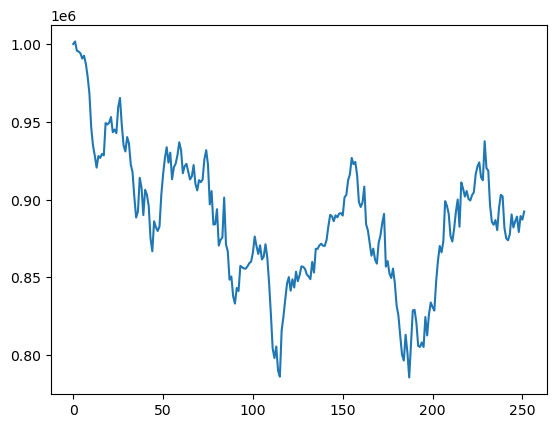

In [35]:
df_account_value.account_value.plot()

In [36]:
print('=============== Backtest Results ===============')
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')
perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)

=============== Backtest Results ===============
Annual return         -0.107672
Cumulative returns    -0.107672
Annual volatility      0.193340
Sharpe ratio          -0.495137
Calmar ratio          -0.499491
Stability              0.201202
Max drawdown          -0.215563
Omega ratio            0.921728
Sortino ratio         -0.688242
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.051188
Daily value at risk   -0.024738
dtype: float64


In [37]:
print("=============== Baseline Stats ===============")
df_dji_ = get_baseline(
    ticker='^DJI',
    start=df_account_value.loc[0, 'date'],
    end=df_account_value.loc[len(df_account_value)-1, 'date']
)
stats = backtest_stats(df_dji_, value_col_name='close')

[*********************100%%**********************]  1 of 1 completed

=============== Baseline Stats ===============
Shape of DataFrame:  (251, 8)
Annual return         -0.094324
Cumulative returns    -0.093968
Annual volatility      0.198502
Sharpe ratio          -0.402058
Calmar ratio          -0.429901
Stability              0.236972
Max drawdown          -0.219408
Omega ratio            0.936015
Sortino ratio         -0.559755
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.014390
Daily value at risk   -0.025326
dtype: float64


In [38]:
df_dji = pd.DataFrame()
df_dji['date'] = df_account_value['date']
df_dji['dji'] = df_dji_['close'] / df_dji_['close'][0] * env_kwargs['initial_amount']
df_dji = df_dji.set_index(df_dji.columns[0])
df_dji.to_parquet(f"{RESULTS_DIR}/df_dji+.parquet")
print('df_dji: ', df_dji)
df_account_value.to_parquet(f"{RESULTS_DIR}/df_account_value+.parquet")

df_dji:                       dji
date                    
2022-01-03  1.000000e+06
2022-01-04  1.005866e+06
2022-01-05  9.951360e+05
2022-01-06  9.904718e+05
2022-01-07  9.903404e+05
...                  ...
2022-12-27  9.086102e+05
2022-12-28  8.986103e+05
2022-12-29  9.080428e+05
2022-12-30  9.060324e+05
2023-01-03           NaN

[252 rows x 1 columns]


df_result_ensemble.columns:  Index(['ensemble'], dtype='object')
df_trade_date:         datadate
0    2021-10-04
1    2021-10-05
2    2021-10-06
3    2021-10-07
4    2021-10-08
..          ...
348  2023-02-22
349  2023-02-23
350  2023-02-24
351  2023-02-27
352  2023-02-28

[353 rows x 1 columns]
df_result_ensemble:                  ensemble
date                    
2022-01-03  1.000000e+06
2022-01-04  1.001603e+06
2022-01-05  9.956672e+05
2022-01-06  9.951256e+05
2022-01-07  9.939838e+05
...                  ...
2022-12-27  8.890841e+05
2022-12-28  8.791907e+05
2022-12-29  8.894135e+05
2022-12-30  8.871188e+05
2023-01-03  8.923283e+05

[252 rows x 1 columns]
=============== Compare to DJI ===============
result                 ensemble           dji
date                                  
2022-01-03  1.000000e+06  1.000000e+06
2022-01-04  1.001603e+06  1.005866e+06
2022-01-05  9.956672e+05  9.951360e+05
2022-01-06  9.951256e+05  9.904718e+05
2022-01-07  9.939838e+05  9.903404e+05
...   

<Axes: xlabel='date'>

<Figure size 1500x500 with 0 Axes>

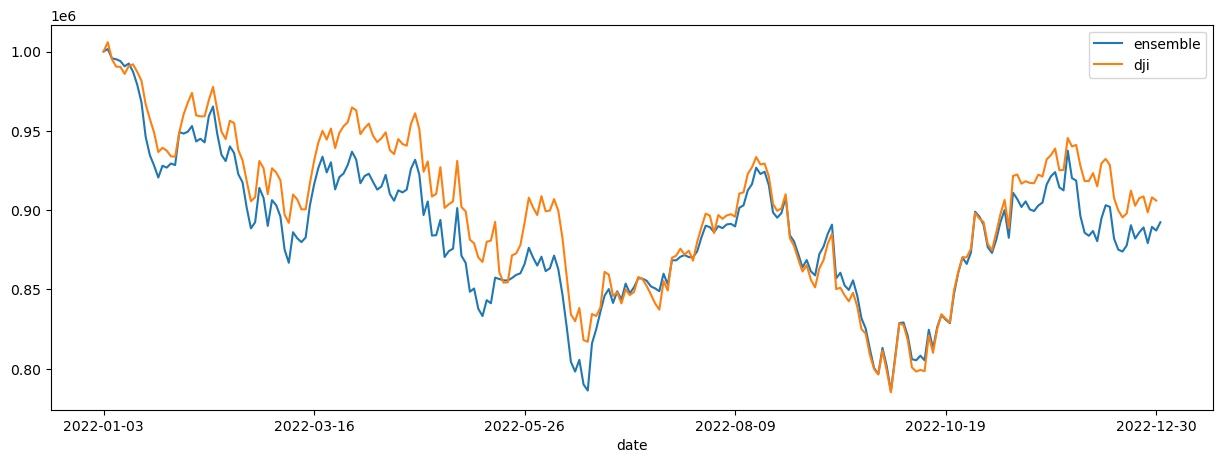

In [41]:
# print('=============== Compare to DJI ===============')
# %matplotlib inline
# backtest_plot(
#     df_account_value,
#     baseline_ticker='^DJI',
#     baseline_start=df_account_value.loc[0, 'date'],
#     baseline_end=df_account_value.loc[len(df_account_value)-1, 'date']
# )
df.to_parquet(f"{RESULTS_DIR}/df.parquet")
df_result_ensemble = pd.DataFrame({'date': df_account_value['date'], 'ensemble': df_account_value['account_value']})
df_result_ensemble = df_result_ensemble.set_index('date')

print('df_result_ensemble.columns: ', df_result_ensemble.columns)
print('df_trade_date: ', df_trade_date)
df_result_ensemble.to_parquet(f"{RESULTS_DIR}/df_result_ensemble.parquet")
print('df_result_ensemble: ', df_result_ensemble)
print('=============== Compare to DJI ===============')
result = pd.DataFrame()
result = pd.merge(df_result_ensemble, df_dji, left_index=True, right_index=True)
print('result', result)
result.to_parquet(f"{RESULTS_DIR}/result.parquet")
result.columns = ['ensemble', 'dji']

%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 5]
plt.figure()
result.plot()